### Importing Modules

In [2]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
from torchvision.datasets import CIFAR100

### Setting the hyperparameters

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 100  # Updated for CIFAR-100
PATCH_SIZE = 4
IMG_SIZE = 32  # Updated for CIFAR-100
IN_CHANNELS = 3  # Updated for CIFAR-100 (RGB)
NUM_HEADS = 8
DROPOUT = 0.01
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS  # Updated
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # Updated

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

### Patch Embedding with position embedding

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)  # Fixed shape
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # Expand for batch size

        x = self.patcher(x).permute(0, 2, 1)  # (B, num_patches, embed_dim)
        x = torch.cat([cls_token, x], dim=1)  # Add CLS token
        x = self.position_embeddings + x  # Add positional embeddings
        x = self.dropout(x)
        return x

# Model instantiation
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)

# Test with CIFAR-100-sized batch
x = torch.randn(512, 3, 32, 32).to(device)  # Updated input tensor
print(model(x).shape)  # Should output (512, num_patches+1, embed_dim)

torch.Size([512, 65, 48])


### VIT implementation with encoder and MLP

In [5]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # CLS token used for classification
        return x

# Instantiate model for CIFAR-100
model = ViT(NUM_PATCHES, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)

# Test with CIFAR-100-sized batch
x = torch.randn(512, 3, 32, 32).to(device)  # Updated input tensor
print(model(x).shape)  # Expected output: (512, 100)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 100])


### Dataset Preparation

In [6]:
# Define CIFAR-100 transforms (Normalization values are from official dataset preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# Load CIFAR-100 dataset
train_dataset = CIFAR100(root="./data", train=True, transform=transform, download=True)
test_dataset = CIFAR100(root="./data", train=False, transform=transform, download=True)

# Split training set into train and validation (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

100%|██████████| 169M/169M [00:03<00:00, 44.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Train Dataset

In [7]:
class CIFAR100TrainDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": idx}

class CIFAR100ValDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": idx}

class CIFAR100TestDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # No label in test set
        image = self.transform(image)
        return {"image": image, "index": idx}

### Train Data Plot

<Figure size 1000x500 with 0 Axes>

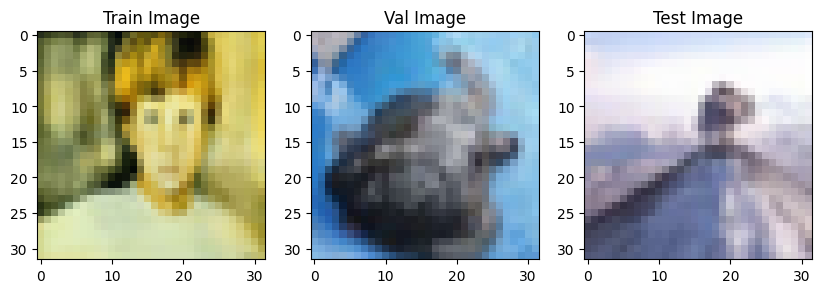

In [8]:
# Get samples using indices from the original dataset
train_idx = train_dataset.indices[0] if hasattr(train_dataset, 'indices') else 0
val_idx = val_dataset.indices[0] if hasattr(val_dataset, 'indices') else 0

train_sample, _ = train_dataset.dataset[train_idx]  # Access original dataset
val_sample, _ = val_dataset.dataset[val_idx]
test_sample, _ = test_dataset[0]  # No change for test dataset

# Convert (C, H, W) to (H, W, C) for visualization
train_sample = train_sample.permute(1, 2, 0).numpy()
val_sample = val_sample.permute(1, 2, 0).numpy()
test_sample = test_sample.permute(1, 2, 0).numpy()

# CIFAR-100 normalization (denormalize for visualization)
mean = np.array([0.5071, 0.4867, 0.4408])
std = np.array([0.2675, 0.2565, 0.2761])

train_sample = (train_sample * std + mean).clip(0, 1)
val_sample = (val_sample * std + mean).clip(0, 1)
test_sample = (test_sample * std + mean).clip(0, 1)

# Plot images
plt.figure(figsize=(10, 5))
f, axarr = plt.subplots(1, 3, figsize=(10, 5))

axarr[0].imshow(train_sample)
axarr[0].set_title("Train Image")

axarr[1].imshow(val_sample)
axarr[1].set_title("Val Image")

axarr[2].imshow(test_sample)
axarr[2].set_title("Test Image")

plt.show()

### Training the model

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_correct, train_total, train_running_loss = 0, 0, 0

    for idx, (img, label) in enumerate(tqdm(train_loader, position=0, leave=True)):
        img, label = img.to(device), label.to(device, dtype=torch.long)  # Ensure correct dtype

        y_pred = model(img)
        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        # Compute accuracy
        y_pred_label = torch.argmax(y_pred, dim=1)
        train_correct += (y_pred_label == label).sum().item()
        train_total += label.size(0)

    train_loss = train_running_loss / (idx + 1)
    train_accuracy = train_correct / train_total

    # Validation phase
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (img, label) in enumerate(tqdm(val_loader, position=0, leave=True)):
            img, label = img.to(device), label.to(device, dtype=torch.long)

            y_pred = model(img)
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()

            # Compute accuracy
            y_pred_label = torch.argmax(y_pred, dim=1)
            val_correct += (y_pred_label == label).sum().item()
            val_total += label.size(0)

    val_loss = val_running_loss / (idx + 1)
    val_accuracy = val_correct / val_total

    print("-" * 30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {train_accuracy:.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {val_accuracy:.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  8%|▊         | 7/88 [02:03<22:54, 16.96s/it]

In [ ]:
torch.cuda.empty_cache()

### Evaluation the model

In [ ]:
labels = []
imgs = []
model.eval()
with torch.no_grad():
    for img, _ in tqdm(test_loader, position=0, leave=True):  # Use (img, label) format
        img = img.to(device)
        outputs = model(img)

        # Store predictions
        labels.extend(torch.argmax(outputs, dim=1).cpu().tolist())  # Convert to list

In [ ]:
# Load a few test images again for visualization
test_samples, _ = next(iter(test_loader))  # Get a batch of test images
test_samples = test_samples[:6]  # Take first 6 images

# Forward pass through the model
model.eval()
with torch.no_grad():
    outputs = model(test_samples.to(device))
    predictions = torch.argmax(outputs, dim=1).cpu().tolist()

# Plot the images with their predicted labels
plt.figure()
f, axarr = plt.subplots(2, 3, figsize=(10, 6))  # Adjust figure size
counter = 0
for i in range(2):
    for j in range(3):
        img = test_samples[counter].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        img = (img * np.array([0.2675, 0.2565, 0.2761])) + np.array([0.5071, 0.4867, 0.4408])  # Denormalize
        img = img.clip(0, 1)  # Ensure valid pixel range

        axarr[i][j].imshow(img)  # No cmap needed for RGB
        axarr[i][j].set_title(f"Predicted {predictions[counter]}")
        axarr[i][j].axis("off")  # Hide axes for cleaner visualization
        counter += 1

plt.show()